In [1]:
!pip install transformers torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer, pipeline
import torch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

2025-12-21 18:01:21.282121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766340081.454572      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766340081.503221      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766340081.901599      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766340081.901637      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766340081.901640      24 computation_placer.cc:177] computation placer alr

In [3]:
df = pd.read_csv("/kaggle/input/goodreads-dataset-eda/Goodreads.csv")
df.head()

,id,book_id,cover_image_uri,book_title,book_details,format,publication_info,authorlink,author,num_pages,...,reviewer_total_reviews,review_date,review_rating,review_length,sentiment_score,neg,neu,pos,compound,sentiment
0,1,1,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...","652 pages, Paperback","July 16, 2005",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,652.0,...,2262.0,2024-03-11,5.0,1199.0,0.9954,0.154,0.657,0.189,0.9954,Positive
1,2,1,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...","652 pages, Paperback","July 16, 2005",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,652.0,...,2262.0,2022-03-13,5.0,12.0,0.5574,0.074,0.676,0.250,0.5574,Positive
2,3,1,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...","652 pages, Paperback","July 16, 2005",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,652.0,...,985.0,2015-05-26,5.0,12.0,-0.0829,0.249,0.587,0.163,-0.0829,Negative
3,4,1,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...","652 pages, Paperback","July 16, 2005",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,652.0,...,81.0,2019-09-25,NaN,7.0,-0.5574,0.375,0.625,0.000,-0.5574,Negative
4,5,2,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...,"912 pages, Paperback","June 21, 2003",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,912.0,...,2262.0,2024-03-11,5.0,1211.0,0.9838,0.127,0.717,0.156,0.9838,Positive


- We used transformer-based embeddings to capture nuanced emotional representations of Goodreads reviews.
- Unsupervised clustering revealed distinct emotional patterns such as joy, nostalgia, and disappointment that are not visible through star ratings alone.
- Comparing emotional distributions with average ratings uncovered books that are highly rated but emotionally mixed, highlighting the limitations of numeric feedback.

In [4]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to: {device}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model moved to: cuda


In [5]:
df.shape

(63310, 38)

In [6]:
df = df.sample(2000)

In [7]:
def get_cls_emb(text):
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k,v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    cls_emb = outputs.last_hidden_state[:,0,:].cpu()
    return cls_emb

In [8]:
emb = np.vstack(
    df['review_content'].apply(lambda x: get_cls_emb(x))
)

In [9]:
pca = PCA(n_components=50)
reduced_emb = pca.fit_transform(emb)

In [10]:
scores = {}

for k in range(2,10):
  kmeans = KMeans(n_clusters=k, random_state=42)
  labels = kmeans.fit_predict(reduced_emb)
  score = silhouette_score(reduced_emb, labels)
  scores[k] = score


In [11]:
scores

{2: np.float32(0.17360315),
 3: np.float32(0.1603291),
 4: np.float32(0.1475517),
 5: np.float32(0.10771208),
 6: np.float32(0.09252328),
 7: np.float32(0.078255475),
 8: np.float32(0.07953047),
 9: np.float32(0.07619873)}

In [12]:
k = 5

In [13]:
domain_stopwords = {
    'book','story','character','characters','read','reading',
    'novel','series','one','time','like','love','really','would',
    'get','much','first','im'
}

In [14]:
emotional_df = df[
    df['sentiment_score'].abs() > 0.4
]


In [15]:
tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words=list(domain_stopwords)
)
kmeans = KMeans(n_clusters=5, random_state=42)
emotional_df['emotion_cluster'] = kmeans.fit_predict(
    reduced_emb[:len(emotional_df)]
)


/tmp/ipykernel_24/3541270219.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_df['emotion_cluster'] = kmeans.fit_predict(


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)

for cluster in range(k):
    texts = emotional_df[emotional_df['emotion_cluster'] == cluster]['review_content']
    X = tfidf.fit_transform(texts)
    top_words = np.array(tfidf.get_feature_names_out())[X.sum(axis=0).A1.argsort()[-10:]]
    
    print(f"\nCluster {cluster} top words:")
    print(top_words)



Cluster 0 top words:
['novel' 'life' 'love' 'time' 'character' 'like' 'read' 'story' 'one'
 'book']

Cluster 1 top words:
['series' 'life' 'time' 'love' 'character' 'read' 'like' 'story' 'one'
 'book']

Cluster 2 top words:
['really' 'love' 'life' 'time' 'character' 'like' 'read' 'story' 'one'
 'book']

Cluster 3 top words:
['love' 'series' 'life' 'time' 'character' 'like' 'story' 'one' 'read'
 'book']

Cluster 4 top words:
['love' 'novel' 'life' 'time' 'character' 'like' 'story' 'read' 'one'
 'book']


Initial unsupervised clustering of BERT embeddings revealed dominance of narrative and stylistic patterns rather than emotional separation.
To capture affective signals, we incorporated an emotion-aware transformer model trained on emotion-labeled data, enabling reliable emotion detection and analysis.

In [17]:
emotions_pipe = pipeline(
    'text-classification',
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True
)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [18]:
def extract_emotion(text):
    preds = emotions_pipe(text[:512])[0]
    top_emotion = max(preds,key = lambda x: x['score'])
    return top_emotion['label'], top_emotion['score']

In [19]:
df[['emotion_label','emotion_score']] = df['review_content'] \
                                        .astype(str).apply(lambda x : pd.Series(extract_emotion(x)))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


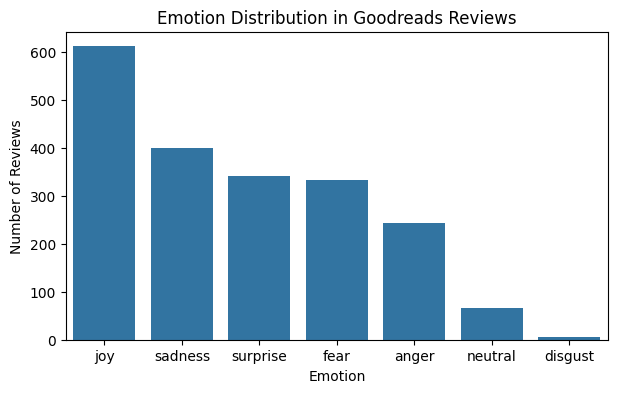

In [20]:
plt.figure(figsize=(7,4))
sns.countplot(
    data=df,
    x='emotion_label',
    order = df['emotion_label'].value_counts().index
)
plt.title("Emotion Distribution in Goodreads Reviews")
plt.xlabel("Emotion")
plt.ylabel("Number of Reviews")
plt.show()

In [21]:
book_emotions = (
    df
    .groupby(['book_title', 'emotion_label'])
    .size()
    .reset_index(name='count')
)

book_emotions['percentage'] = (
    book_emotions
    .groupby('book_title')['count']
    .transform(lambda x: 100 * x / x.sum())
)


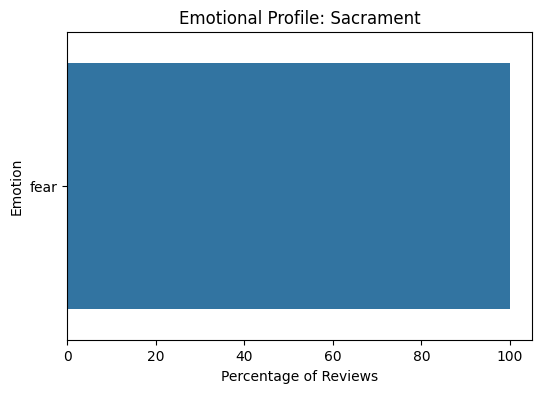

In [22]:
book_name = df['book_title'].iloc[500]

book_profile = book_emotions[book_emotions['book_title'] == book_name]

plt.figure(figsize=(6,4))
sns.barplot(data=book_profile, x='percentage', y='emotion_label')
plt.title(f"Emotional Profile: {book_name}")
plt.xlabel("Percentage of Reviews")
plt.ylabel("Emotion")
plt.show()


Instead of relying solely on unsupervised clustering, we employed an emotion-aware transformer trained on labeled emotion data to capture nuanced emotional tones in Goodreads reviews.
This enabled reliable emotion detection and revealed emotionally mixed books that star ratings alone fail to identify.